<a href="https://colab.research.google.com/github/Lemon-Aki/DeepLearningFromScratch1/blob/main/Chapter6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# 코랩과 구글드라이드를 연동(인증 필요)
#Transport endpoint is not connected 에러시 코랩 재연결
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive/DeepLearningFromScratch1/

Mounted at /gdrive
/gdrive/MyDrive/DeepLearningFromScratch1


In [10]:
#신경망 학습의 목적 : 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는것
#최적화 : 매개변수의 최적값을 찾는 문제를 푸는것
#확률적 경사 하강법(SGD, Stochastic Gradient Descent): 매개변수의 기울기(미분)을 구해, 가장 크게 기울어진 방향으로 매개변수값을 갱신하는 것을 반복
#SGD 단점 : 비등방성 함수(방향에따라 성질(기울기)가 달라지는 함수)에서는 경색 탐로가 비효율적, 기울어진 방향이 본래의 최솟값과 다른 방향을 가리키는 점
class GSD:
  def __init__(self, lr=0.01):  #lr:학습률
    self.lr = lr

  def update(self, params, grads):  #params:가중치, grads:기울기(미분값)
    for key in params.keys():
      params[key] -= self.lr * grads[key]

In [11]:
#모멘텀(Momentum) : 운동량, 공이 그릇의 곡면을 따라 구르듯 움직이는 이미지
#v <- αv - n(학습률) * ∂L/∂W (W(갱신할 가중치 매개변수)에 대한 손실함수의 기울기)
#W <- W + v(v:velocity, 물리에서 말하는 속도)
#αv항:물체가 아무런 힘을 받지 않을때 서서히 하강시키는 역할(지면 마찰, 공기저항 등)
class Momentum:
  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None
  
  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)
    
    for key in params.keys():
      self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
      params[key] += self.v[key]

In [12]:
#학습률 : 너무 작으면 학습 시간이 길어지고 너무 크면 발산해서 학습이 안됌
#학습률 감소(learning rate decay) : 학습을 진행하면서 학습률을 줄여나가는 방법
#AdaGrad(Adaptive Gradient): 각각의 매개변수에 적응적으로 학습률을 조정하면서 학습을 진행, 과거의 기울기를 제곱하여 계속 더해감
#예)y축 방향으로 기울기가 클때 처음에는 크게 움직여도, 갱신정도도 큰 폭으로 작아지도록 조정되어, y축방향으로는 갱신 강도가 빠르게 약해짐
#RMSProp(Root Mean Square Propatation):AdaGrad를 무한히 하면 어느순간 갱신량이 0이 되는 문제를개선,
#먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영하는 지수이동평균(EMA)를 사용
class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

    for key in params.keys():
      self.h[key] += grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) #self.h[key]에 0이더라도 0으로 나누는 사태를 막아줌

In [13]:
#Adam(Adaptive Moment Estimation) 알고리즘 : 모멘텀과 RMSprop을 섞어놓은 최적화 알고리즘, 딥러닝에서 가장 흔히 사용되는 최적화 알고리즘
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


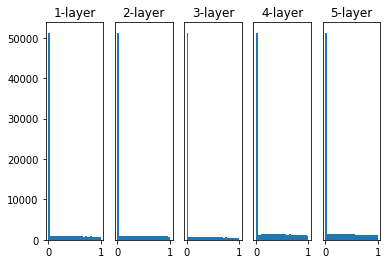

In [14]:
#가중치의 초깃값
#가중치 감소(weight decay) 기법 : 오버피팅을 억제해 범용 성능을 높이는 테크닉, 가중치 값을 작게하여 과대적합을 피하기
#가중치의 초기값을 0으로 하면 가중치가 고르게 되어, 곱셈 노드의 역전파에서 같은값이 유지가 되어 가중치를 여러개 갖는 의미가 없음
#은닉층의 활성화함수의 출력 데이터의 분포를 관찰
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    #기울기 소실(gradient vanishing) 문제 : 데이터가 0과 1에 치우쳐 분포하게 되어 역전파의 기울기 값이 점점 작아지다 사라짐
    # w = np.random.randn(node_num, node_num) * 1
    #표현력 제한 문제 : 활성화값이 한쪽에 치우쳐져서, 뉴런을 여러개 둔 의미가 없음
    # w = np.random.randn(node_num, node_num) * 0.01
    #Xavier초깃값: 좌우 대칭이라 중앙 부근이 선형인 함수의 권장 초깃값, 앞 계층의 노드가 n개일 경우, 표준편차가 1/root(n)인 분포를 사용할 것
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    #He초깃값: ReLU함수를 활성화 함수를 사용할 경우의 권장 초깃값, 앞 계층의 노드가 n개일 경우, 표준편차가 root(2/n)인 정규분포 사용
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    # 활성화 함수도 바꿔가며 실험해보자！
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

In [15]:
#가중치의 초깃값을 적절히 설정하면 각 층의 활성화값 분포가 적당히 퍼지면서 학습이 원할히 수행됨
#배치 정규화(Batch Normalization): 각 층이 활성화를 적당히 퍼뜨리도록 강제하기위한 아이디어, 미니배치 단위로 정규화
#장점1 : 학습속도가 빠름
#장점2 : 초깃값에 크게 의존하지 않는다
#장점3 : 과대적합를 억제

epoch:0, train acc:0.11333333333333333, test acc:0.1189
epoch:1, train acc:0.13666666666666666, test acc:0.1347
epoch:2, train acc:0.14, test acc:0.1441
epoch:3, train acc:0.17, test acc:0.1538
epoch:4, train acc:0.17666666666666667, test acc:0.1599
epoch:5, train acc:0.19333333333333333, test acc:0.169
epoch:6, train acc:0.21, test acc:0.1811
epoch:7, train acc:0.21333333333333335, test acc:0.1831
epoch:8, train acc:0.23666666666666666, test acc:0.1888
epoch:9, train acc:0.2733333333333333, test acc:0.1939
epoch:10, train acc:0.2966666666666667, test acc:0.2072
epoch:11, train acc:0.31, test acc:0.2114
epoch:12, train acc:0.33, test acc:0.2176
epoch:13, train acc:0.35, test acc:0.2299
epoch:14, train acc:0.36333333333333334, test acc:0.2424
epoch:15, train acc:0.38, test acc:0.2526
epoch:16, train acc:0.38, test acc:0.2596
epoch:17, train acc:0.38333333333333336, test acc:0.268
epoch:18, train acc:0.39666666666666667, test acc:0.2763
epoch:19, train acc:0.3933333333333333, test acc:0.

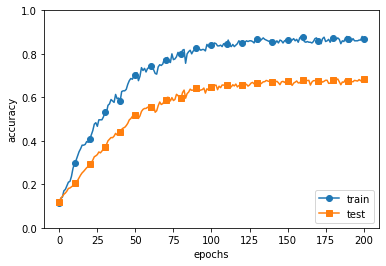

In [16]:
#오버피팅(과대적합): 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태
#원인1 : 매개변수가 많고, 표현력이 높은 모델
#원인2 : 훈련 데이터가 적음
#가중치 감소 : 학습 과정에서 큰 가중치에 대해 그에 상응하는 큰 페널티를 부과하는 방법
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)  #에폭단위의 훈련 정확도 저장
        test_acc = network.accuracy(x_test, t_test)   #에폭단위의 테스트 정확도 저장
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

train loss:2.298803180410301
=== epoch:1, train acc:0.11666666666666667, test acc:0.0974 ===
train loss:2.2981180873240263
train loss:2.283073957619847
train loss:2.290005901855268
=== epoch:2, train acc:0.11333333333333333, test acc:0.0995 ===
train loss:2.313253834074613
train loss:2.3170738314395347
train loss:2.296925797665952
=== epoch:3, train acc:0.11, test acc:0.0992 ===
train loss:2.2874682931864827
train loss:2.3006357901663126
train loss:2.3049942681134463
=== epoch:4, train acc:0.11, test acc:0.1014 ===
train loss:2.2904125247868135
train loss:2.2966029129787384
train loss:2.302914278421629
=== epoch:5, train acc:0.11, test acc:0.1019 ===
train loss:2.2872095002370023
train loss:2.298315132704218
train loss:2.294559647744601
=== epoch:6, train acc:0.11666666666666667, test acc:0.1024 ===
train loss:2.2962129560733304
train loss:2.290340883462771
train loss:2.287332471893301
=== epoch:7, train acc:0.11333333333333333, test acc:0.1029 ===
train loss:2.2947011908755606
train l

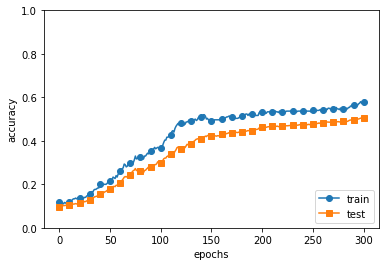

In [20]:
#드롭아웃(dropout): 신경망 모델이 복잡해서 가중치 감소만으로 대응이 어려울때 사용하는 오버피팅 억제 방식,
#훈련때 은닉층의 뉴런을 무작위로 골라 삭제, 시험 때는 모든 뉴런을 사용
#단, 시험때는 각 뉴런의 출력에 훈련때 삭제 안한 비율을 곱하여 출력
#앙상블 학습(Ensemble learning): 새별적으로 학습시킨 여러 모델의 출력을 평균(또는 투표)내어 추론하는 방식
class Dropout:
  def __init__(self, dropout_ratio = 0.15):
    self.dropout_ratio = dropout_ratio
    self.mask = None

  def forward(self, x, train_flg=True):
    if train_flg:
      #x와 형상이 같은 배열을 무작위 생성, dropout_ratio보다 큰 원소만 True로 설정
      self.mask = np.random.rand(*x.shape) > self.dropout_ratio
      return x * self.mask
    else:
      return x * (1.0 - self.dropout_ratio)

  #순전파때 신호를 통과시키는 뉴런은 역전파 때도 신호를 통과, 순전파때 통과시키지 않은 뉴런은 역전파 때도 신호를 차단
  def backward(self, dour):
    return dout * self.mask

from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [23]:
#적절한 하이퍼파라미터 값을 찾는 방법
#1. 검증 데이터 : 하이퍼파라미터를 평가할 때는 시험 데이터를 사용하지 않아야하기 때문에, 
#훈련데이터의 일부를 하이퍼파라미터 조정용 검증데이터로 분리하는 방법 사용
(x_train, t_train), (x_test, t_test) = load_mnist()

#훈련데이터 섞기
from common.util import shuffle_dataset
x_train,t_train = shuffle_dataset(x_train, t_train)

#20%를 검증데이터로 사용
validation_rate = 0.20
validation_num = int(x_train.shape[0]* validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

In [27]:
#2. 하이퍼파라미터 최적화 : 대략적인 범위를 설정하고, 그 범위에서 하이퍼파라미터 값을 골라 샘플링후, 그 값으로 정확도를 평가하는 것을 반복
#최적화에 오랜 시간이 걸리기 때문에 에폭을 작게하는 것이 효과적
#0단계 : 하이퍼파라미터 값의 범위를 설정
#1단계 : 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출
#2단계 : 1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가(에폭은 작게 설정)
#3단계 : 1~2단계를 특정 횟수 반복하여, 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.trainer import Trainer

def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

#실행시간이 오래 걸려서 주석처리
#    val_acc_list, train_acc_list = __train(lr, weight_decay)
#    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
#    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
#    results_val[key] = val_acc_list
#    results_train[key] = train_acc_list

# 그래프 그리기
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

=========== Hyper-Parameter Optimization Result ===========
